In [1]:
import numpy as np
import time
import sys
import os
import random
from skimage import io
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile

import cv2
import tensorflow as tf


### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [2]:
base_path = 'Dataset/Open Images Dataset v4 (Bounding Boxes)'
images_boxable_fname = 'train-images-boxable.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [3]:
images_boxable = pd.read_csv(os.path.join(base_path, images_boxable_fname))
images_boxable.head()

,image_name,image_url
0,e39871fd9fd74f55.jpg,https://requestor-proxy.figure-eight.com/figur...
1,f18b91585c4d3f3e.jpg,https://requestor-proxy.figure-eight.com/figur...
2,ede6e66b2fb59aab.jpg,https://requestor-proxy.figure-eight.com/figur...
3,ed600d57fcee4f94.jpg,https://requestor-proxy.figure-eight.com/figur...
4,ff47e649b23f446d.jpg,https://requestor-proxy.figure-eight.com/figur...


In [4]:
annotations_bbox = pd.read_csv(os.path.join(base_path, annotations_bbox_fname))
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [6]:
class_descriptions = pd.read_csv(os.path.join(base_path, class_descriptions_fname))
class_descriptions.head()

,name,class
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


### Show one image by using these three tables

In [7]:
print('length of the images_boxable: %d' %(len(images_boxable)) )
print('First image in images_boxable👇')
img_name = images_boxable['image_name'][0]
img_url = images_boxable['image_url'][0]
print('\t image_name: %s' % (img_name))
print('\t img_url: %s' % (img_url))
print('')
print('length of the annotations_bbox: %d' %(len(annotations_bbox)))
print('The number of bounding boxes are larger than number of images.')
print('')
print('length of the class_descriptions: %d' % (len(class_descriptions)-1))
img = io.imread(img_url)

length of the images_boxable: 1743042
First image in images_boxable👇
	 image_name: e39871fd9fd74f55.jpg
	 img_url: https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e39871fd9fd74f55.jpg

length of the annotations_bbox: 14610229
The number of bounding boxes are larger than number of images.

length of the class_descriptions: 600


(1024, 768, 3)


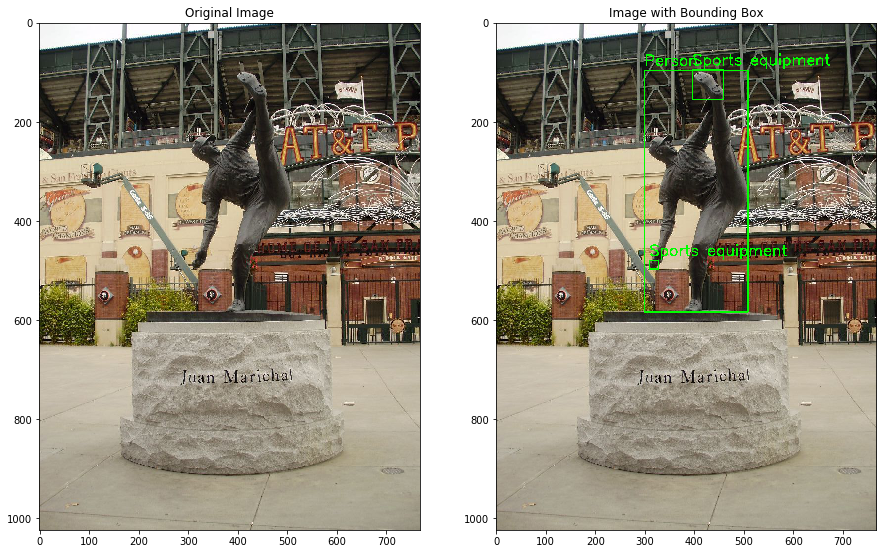

In [8]:
height, width, _ = img.shape
print(img.shape)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
img_id = img_name[:16]
bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
img_bbox = img.copy()
for index, row in bboxs.iterrows():
    xmin = row['XMin']
    xmax = row['XMax']
    ymin = row['YMin']
    ymax = row['YMax']
    xmin = int(xmin*width)
    xmax = int(xmax*width)
    ymin = int(ymin*height)
    ymax = int(ymax*height)
    label_name = row['LabelName']
    class_series = class_descriptions[class_descriptions['name']==label_name]
    class_name = class_series['class'].values[0]
    cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox,class_name,(xmin,ymin-10), font, 1,(0,255,0),2)
plt.subplot(1,2,2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

In [8]:
# io.imsave(os.path.join(base_path,'Person')+'/1.jpg', img)

As we can see, by using these three tables, the image with bounding box could be drawn

### Get subset of the whole dataset

For here, I just want to detect three classes, which include person, mobile phone and car.

The dataset from [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/download.html) is too large for me. So I just extract 1000 images for each class from the whole dataset.

In [9]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
person_pd = class_descriptions[class_descriptions['class']=='Person']
phone_pd = class_descriptions[class_descriptions['class']=='Mobile phone']
car_pd = class_descriptions[class_descriptions['class']=='Car']

label_name_person = person_pd['name'].values[0]
label_name_phone = phone_pd['name'].values[0]
label_name_car = car_pd['name'].values[0]

In [10]:
print(person_pd)
print(phone_pd)
print(car_pd)

         name   class
68  /m/01g317  Person
         name         class
312  /m/050k8  Mobile phone
        name class
570  /m/0k4j   Car


**Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image**

In [9]:
person_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_person]
phone_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_phone]
car_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_car]

NameError: name 'label_name_person' is not defined

In [ ]:
print('There are %d persons in the dataset' %(len(person_bbox)))
print('There are %d phones in the dataset' %(len(phone_bbox)))
print('There are %d cars in the dataset' %(len(car_bbox)))
person_img_id = person_bbox['ImageID']
phone_img_id = phone_bbox['ImageID']
car_img_id = car_bbox['ImageID']

In [ ]:
person_img_id = np.unique(person_img_id)
phone_img_id = np.unique(phone_img_id)
car_img_id = np.unique(car_img_id)
print('There are %d images which contain persons' % (len(person_img_id)))
print('There are %d images which contain phones' % (len(phone_img_id)))
print('There are %d images which contain cars' % (len(car_img_id)))

We just randomly pick 1000 images in here.

In [ ]:
# Shuffle the ids and pick the first 1000 ids
copy_person_id = person_img_id.copy()
random.seed(1)
random.shuffle(copy_person_id)

copy_phone_id = phone_img_id.copy()
random.seed(1)
random.shuffle(copy_phone_id)

copy_car_id = car_img_id.copy()
random.seed(1)
random.shuffle(copy_car_id)

n = 1000
subperson_img_id = copy_person_id[:n]
subphone_img_id = copy_phone_id[:n]
subcar_img_id = copy_car_id[:n]

In [ ]:
print(subperson_img_id[10])
print(subphone_img_id[10])
print(subcar_img_id[10])

In [ ]:
# This might takes a while to search all these urls
subperson_img_url = [images_boxable[images_boxable['image_name']==name+'.jpg'] for name in subperson_img_id]
subphone_img_url = [images_boxable[images_boxable['image_name']==name+'.jpg'] for name in subphone_img_id]
subcar_img_url = [images_boxable[images_boxable['image_name']==name+'.jpg'] for name in subcar_img_id]

In [10]:
subperson_pd = pd.DataFrame()
subphone_pd = pd.DataFrame()
subcar_pd = pd.DataFrame()
for i in range(len(subperson_img_url)):
    subperson_pd = subperson_pd.append(subperson_img_url[i], ignore_index = True)
    subphone_pd = subphone_pd.append(subphone_img_url[i], ignore_index = True)
    subcar_pd = subcar_pd.append(subcar_img_url[i], ignore_index = True)
subperson_pd.to_csv(os.path.join(base_path, 'subperson_img_url.csv'))
subphone_pd.to_csv(os.path.join(base_path, 'subphone_img_url.csv'))
subcar_pd.to_csv(os.path.join(base_path, 'subcar_img_url.csv'))

NameError: name 'subperson_img_url' is not defined

In [18]:
subperson_img_url = [url['image_url'].values[0] for url in subperson_img_url]
subphone_img_url = [url['image_url'].values[0] for url in subphone_img_url]
subcar_img_url = [url['image_url'].values[0] for url in subcar_img_url]
urls = [subperson_img_url, subphone_img_url, subcar_img_url]

In [19]:
subperson_pd = pd.read_csv('Dataset/Open Images Dataset v4 (Bounding Boxes)/subperson_img_url.csv')
subphone_pd = pd.read_csv('Dataset/Open Images Dataset v4 (Bounding Boxes)/subphone_img_url.csv')
subcar_pd = pd.read_csv('Dataset/Open Images Dataset v4 (Bounding Boxes)/subcar_img_url.csv')

subperson_img_url = subperson_pd['image_url'].values
subphone_img_url = subphone_pd['image_url'].values
subcar_img_url = subcar_pd['image_url'].values

urls = [subperson_img_url, subphone_img_url, subcar_img_url]

In [20]:
urls[0][1]

#urls[0][743]

'https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5accc0a51f39559f.jpg'

In [21]:
saved_dirs = [os.path.join(base_path,'Person'),os.path.join(base_path,'Mobile phone'),os.path.join(base_path,'Car')]

In [22]:
classes = ['Person', 'Mobile phone', 'Car']

In [23]:
print(len(urls[0]))
print(urls[0][0])
#print(saved_paths)

1000
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1a76122aab7176d8.jpg


### Download images

In [24]:
from tqdm import tqdm

# Download images
for i in tqdm(range(len(classes))):
    # Create the directory
    os.mkdir(saved_dirs[i])
    saved_dir = saved_dirs[i]
    for url in urls[i]:
        print(url)
        img = io.imread(url)
        saved_path = os.path.join(saved_dir, url[-20:])
        io.imsave(saved_path, img)

  0%|          | 0/3 [00:00<?, ?it/s]

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1a76122aab7176d8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5accc0a51f39559f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f607867752dd80e9.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/47df981ba82e224c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/aff1b59bccb0f6cb.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/493451d242a4db07.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/52c3df5c80e17b7d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d7f6bd8eaaa895e8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/073af2b33d6dae8d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/569e818f18eee86e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2441e669c860fa4a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ec33a957da2a786c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b451743f1474e6c1.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1ca13af59ee868e8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/70450b2a394ef0eb.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2bee9b3fb726d09a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f331a98e63e5ed2b.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/70b6aeaa5990e9c0.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/80c32795d74904c7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8d3afde28b20921a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0bd8b0dc3dd2fc6a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c9505cc87612cf51.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b749b750c534a62f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/30c75024c50b80e5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/388a9d1e00a82631.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/382fdd422a923f4e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2e0e392e9443ff01.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6e4c54782b97f9b2.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/58409f82754881a7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d6239779e5cbc196.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8b88f1d3049fe715.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/86e5de18ae64ae85.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/297b02110964fc88.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6908e7e61951ac8c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9b1dc09ab79b1821.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/768873cd4d39853a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/16a088c7430fc70a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/904d77aba68606d5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b307da7a2059b00e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2312c339d2acf1c8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0d7c2f996a1524b8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4164ddcbebd2b196.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/59e8c9f16bec25bd.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c28c5b165499f775.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1e290ad96c1549f8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d891339d26c666ef.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/167ba5795e694b8e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f26b39baeb641170.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3b550d885dbaa0d1.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/834b2692f18646a3.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/befe79cec510d61a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/fcd1a1a5b8cc5208.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/808667ba5f18aeee.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/58bf53838220ef08.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/00edd8ea2a8889d3.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/089f8e5b0f78ce1b.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d300849b2d468973.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/308c3fa6d39420c8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/7a6a2a13e808b34d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/689f0de3fb653342.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a7fa8c6849b9f1f4.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/18127291eb407c15.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8569912c5f68a3a9.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/073f0d62f0b8f167.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1244494a2e98ba18.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d447023dc46e959e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/7b04daf3dd169be6.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5e5f552d6057ef96.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1a3d0747be1b479d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/cbaaffdeab020e8c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c08e3dd8bac01a00.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6dcfcc2dfe959b15.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ed55f52ea4a3e15b.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/380919d40d45182c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/fb5c14c5ba378f4a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ebb6192d9ebf64e6.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/62d5b13aea8adb58.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/27be7508cc69f3c0.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/bc0fe0ae42c509c3.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/14c9fafc77bb30eb.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2adbee8d4648413b.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/131e61c47aa26df8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a7dd7d4de7e76203.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/bd04f003d5a3bb8a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ec84d9b154e566b7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2c924f4e4919f2a7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9e35734be16c76f4.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f8b1adab223f9608.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/7e28c7f927f66db2.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e8ff855e3a6e9b32.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/759bb801cf7eb44a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f00c08d674749900.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e1fc11e86fbd3790.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/aee330c903f00f25.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/449514fa5e4164c0.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d128e9598f8bee82.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/833fb9525fe0650d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/148dc2b9b7452883.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2facd6a563e58eda.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8f1b6d0d2a02b8b6.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ad51c46a19ce660d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/58cd19cae9fbc0bc.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5aa2b94019997808.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a45d58b2b32423d9.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/250c385faace4b25.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1cb00ba1bf2f3bd3.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ac894f185667a19c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/78fa899ae58193cb.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8ffd6264026d4e80.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3be004e858bf77de.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/54df81c313908d7f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e9aaad62251e1e10.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/89c9e82bbb96a02d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/bb0e36c539ea884a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/27fb2a1a512ac439.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/eef093538a43db1c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a04399632732d368.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8

 33%|███▎      | 1/3 [59:12<1:58:25, 3552.65s/it]

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/91ec0ff3f1e2f9f5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9adaaa25edd61190.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f4f4df040a402389.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3bc879cee2c997b0.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/88b13fdaccf25c81.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/306304808e3fc575.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/167f31a629ed3ba3.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/413286aea3c82160.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/641a8e4e6253cdc5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ea395dbbf1ef3014.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2ea589e2e3d54b91.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5913334db36ce4ca.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3e01dad6d28b6269.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0443cb53ea29b2b7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9491079ef20b8e51.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8c8a96fa11fcd8c7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/838c5672e7a5e4ed.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/71d3e3c77d5a432c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/30a78348504980c9.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5dbc1700374e6a17.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/019e34019dc342f6.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f0df71c6491bf239.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/67f65d9ff4e5d2c1.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/af056d070b1da63c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/fffcbc0b28c934f7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6f9a87acc82ccdae.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f6454a7fd946f80f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/fbcf9739589e2463.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c3394ac5a22ec951.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/bef83d093b9ea9c5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/735fb9279b7fec0d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0a975d273e02c983.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f1d3928e3d1e32f0.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4d5478d0a04aeaa0.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f121b7bb1fdcc03b.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/fbbff3e64feef1dc.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9bdc6d2138870407.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0cf6d2c75944bfe7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3bb74dbb36079510.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/22ad2df856372d40.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/57f94094f65618fe.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c394035c9abda60a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6534c55b6c1742d2.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/cea6e0283e48a9ee.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/de9a6a46b08ac763.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c6f4d12d0c579061.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4738588bab80b3e5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4c40a90d384d9f6a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d763da119b65238e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3466f5a285df8945.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9d73b3399febeb09.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b839c515de3d3257.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/232cfc6e42314a50.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/06992dd1f046d8fb.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/767d20b7d92e2fe9.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4a07bca96ffce580.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e4f2aa35c4d82a1b.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/641c2ed780bb005d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ecaa9c8b324de1ae.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/26e24a62fbced51b.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/335b50bb17d68b63.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/64a55f08149ea16a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6ad03829ab003de4.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/44bc3bf957f71da2.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/06e5f6e7eeb0f55f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/49de2c1047faa37a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4807330ca73465dd.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9a0fb58aa01c0ed0.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ec04ff0dc10423a8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8351429d30cce164.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d555bf8714a6177d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0b535bb5bd5936b8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/7

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f6155913e2244998.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/fe22e106b365634a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/00820c80468d1854.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1d09b6208473c6e6.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/904a828416bb3830.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/037aaaf3346af356.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/17718a81448e8327.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1d79f2309275dfd9.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/bfd6a1d05d970d08.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/000f9ebbd5fc3745.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b2a1eabf5402cda3.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6a0a92216c12ccba.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4d31d34fb44bfbb4.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/fef169aa366115a1.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0d85175a8977a735.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/18d6424e705a2757.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/61df3d6d67868a48.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/cdc5153a86b2b833.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/33354987a1dfd7d5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b8d04dee3b47bab7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b77f9f77c97f2a07.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0584472b0ce3ecfb.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b2d3428aa59314bd.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6a16dc4790bbade2.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4d0a090f5609295d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/78f43d0878347b31.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/554fdc3d15cfddd8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/72c71278afc338ff.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/93486e848c93019e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c1d21d708f4e4ab1.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3a522003dc097f9c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1ab4f1305d0ea276.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/49619fcfa8d5d9fa.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/fcbd27d7289ac157.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5a99f4ae9d3419b5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0eb1e9e367368a5d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0e5b07d16a2bf1e7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0a4244f8a9185bad.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/042f5fb9fad0d98f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/04448e944382eb08.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/cb7a16d5d5dc2e0e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5d5ceb9d46b7ccee.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/bb8c6d3b6554a095.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9cd5bdd04d2daa26.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/623bc9fd0f2589ad.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c

 67%|██████▋   | 2/3 [1:37:38<52:58, 3178.68s/it]

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/80f523931b1939e1.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/04a8a9b075fbb0dd.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/12b62b6bb202ddef.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/cd4da27d2103c83e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ea37fe6d53c37f29.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b4140e5eab27335e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/abf7575a1ee24d5f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2b1be542a039eeea.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6ebd5d4ca11e47f1.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/952a0cd4e90e13ec.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2096c401876b7f33.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9dea648da6e87e93.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/477a2a475b47eb4d.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3c90454562f5f1ff.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/eb71ffea584ca9f5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/24b75ecacab8fe8e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a4f367658ecab05f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/15c87190eb20767b.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2edebded3bc16bb6.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4c91b25f94b497e4.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/88192075c621e12e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/11eef5aec6951d67.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d8a2052678d7c888.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c1b126cfd6227578.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/cac6438c113a119f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d6c8373563f3b5ae.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e0fa09b7707064e9.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c0130943dc8e2b2f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/012fbcc5db3bfb41.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1fa91427100927da.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0161865177935b8c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2f039259ca9b8df5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2ad8d7ae0a9bd9d0.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a804fbb55d82d710.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ac88a5dfb63eec40.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/6ebff5ceda8733bd.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f54bfe043d687505.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/623f070e716d5600.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/706ba6a724066d60.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/38ac910d3e014469.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e8ccc360471cc756.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c02c87386baeff26.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4089d158a13f89ed.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/cc753642a70d88dc.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/69b98f9f3f547a57.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/7

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2b74894404139dbd.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/300f7c8fe2cee799.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5cba55423b18f0ad.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/39e7f2ab59cf27b5.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/131180f09b7d4506.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/64dc355b4275164a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0ae3874d047fe3d3.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/74d830ea1deccc56.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c65645ee172db961.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/22570723d36d2c5f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4baf1b14fe7714f1.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/cf7c4565a9155db2.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/cd960e8c1adc2460.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/15bdda414350241a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/968a30058ad24266.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/932dfbd61bcf39d4.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2f9fab178beb0e42.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b732bf04f270e39b.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b54a5ae38764fbd7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/7e2352a79a9355fc.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e15c25368a539a67.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/939c796b2959c0cf.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3c578df5d1e6ad00.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8cd166f11e3afefe.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d875551ea504cb52.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/744d7e5e4eefd0aa.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/93137d856f22dece.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a2543d9536074c05.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ecdc0e726b34d0af.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9d4dc71c8849c1ab.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/13c73dcbc25bddf6.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0044535b6c092973.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/567d703882fd819c.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/807fbe95934de037.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1c0e16aea2273b60.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/69ad529f6536c773.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ad9355e5bf421afd.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/7d96fec610e5eee7.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/06d6fd2c67b39bfd.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/2a2a9bae8748fa29.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/307c6952fae11278.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b964cd083b3291c4.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d354c0b136f61976.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/85b0b8edccaaccc0.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/94e8fdb3ac67fe39.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/7

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/8e29db5b87af2d76.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/9212921605df0f77.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a45174d242e4b9c9.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a8e8d4259eecd132.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b52b26534ee81452.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/0fbd167a0dc616f6.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/f81a8aacf9f2a0c3.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/ec04c57bf08e4813.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5d830ab17a26d6ae.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/051492253f45745e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/663e36751b979458.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b5a554338d7944e2.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/a28b472e4ebcc150.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c2e31869b9a0c55e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/451bd377f5357510.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4630ac66c4b734c8.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5655eb775ce6affc.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e9ee44407082995f.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/1

https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/cf1a99bdd385b325.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/c151676fc6219ecb.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/d457db3e59046434.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b229e7f16de61ae2.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/7f66cca32acc8e7e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/7303c91e6e63a98a.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b42a72dc39b36178.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/aac90c31efcdf200.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/b1fe50bf3430f13e.jpg
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/3

100%|██████████| 3/3 [2:21:32<00:00, 2830.68s/it]


### Prepare dataset format for faster rcnn code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [91]:
# Save images to train and test directory
train_path = os.path.join(base_path, 'train')
os.mkdir(train_path)
test_path = os.path.join(base_path, 'test')
os.mkdir(test_path)

for i in range(len(classes)):
    
    all_imgs = os.listdir(os.path.join(base_path, classes[i]))
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.seed(1)
    random.shuffle(all_imgs)
    
    train_imgs = all_imgs[:800]
    test_imgs = all_imgs[800:]
    
    # Copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(os.path.join(base_path, classes[i]), train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # Copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(os.path.join(base_path, classes[i]), test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)


In [92]:
print('number of training images: ', len(os.listdir(train_path))) # subtract one because there is one hidden file named '.DS_Store'
print('number of test images: ', len(os.listdir(test_path)))

number of training images:  2396
number of test images:  600


The expected number of training images and validation images should be 3x800 -> 2400 and 3x200 -> 600.

However, there might be some overlap images which appear in two or three classes simultaneously. For instance, an image might be a person walking on the street and there are several cars in the street

In [93]:
label_names = [label_name_person, label_name_phone, label_name_car]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [95]:
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                test_df = test_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [96]:
train_df.to_csv(os.path.join(base_path, 'train.csv'))
test_df.to_csv(os.path.join(base_path, 'test.csv'))

### Write train.csv to annotation.txt

In [ ]:
# print(train_df.head())
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))

# For training
f= open(base_path + "/annotation.txt","w+")
for idx, row in train_df.iterrows():
#     sys.stdout.write(str(idx) + '\r')
#     sys.stdout.flush()
    img = cv2.imread((base_path + '/train/' + row['FileName']))
    height, width = img.shape[:2]
    x1 = int(row['XMin'] * width)
    x2 = int(row['XMax'] * width)
    y1 = int(row['YMin'] * height)
    y2 = int(row['YMax'] * height)
    
    google_colab_file_path = 'Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
    fileName = os.path.join(google_colab_file_path, row['FileName'])
    className = row['ClassName']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
f.close()

In [ ]:
print(test_df.head())
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

# For test
f= open(base_path + "/test_annotation.txt","w+")
for idx, row in test_df.iterrows():
    sys.stdout.write(str(idx) + '\r')
    sys.stdout.flush()
    img = cv2.imread((base_path + '/test/' + row['FileName']))
    height, width = img.shape[:2]
    x1 = int(row['XMin'] * width)
    x2 = int(row['XMax'] * width)
    y1 = int(row['YMin'] * height)
    y2 = int(row['YMax'] * height)
    
    google_colab_file_path = 'Dataset/Open Images Dataset v4 (Bounding Boxes)/test'
    fileName = os.path.join(google_colab_file_path, row['FileName'])
    className = row['ClassName']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
f.close()